# Bluetooth DoS Classifier

This experiment introduced benign captured data used to balance the dataset. This change caused the TF-IDF features count to increase exponentially to 10s of thousands of features. The feature count was reduced to only 1000 features for performance reasons.

**Findings:**

- The model increased its accuracy significantly
- The model maintained its performance with live data

## Setup

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots as _
import seaborn as sns
import sklearn.metrics as metrics
from joblib import dump, load
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from wordcloud import WordCloud

In [4]:
DATA = os.path.abspath("../data")
MODELS = os.path.abspath("../models")

# data paths
ATTACK_TRAIN = os.path.join(DATA, "dos_train.csv")
BENIGN_TRAIN = os.path.join(DATA, "benign_train.csv")
ATTACK_TEST = os.path.join(DATA, "dos_test.csv")
BENIGN_TEST = os.path.join(DATA, "benign_test.csv")
CAPTURED_DATA = os.path.join(DATA, "capture.csv")

# preprocessed data paths
PREPROCESSED_TRAIN = os.path.join(DATA, "preprocessed_train.csv")
PREPROCESSED_TEST = os.path.join(DATA, "preprocessed_test.csv")
LABELS_TRAIN = os.path.join(DATA, f"labels_train.npy")
LABELS_TEST = os.path.join(DATA, f"labels_test.npy")

# features paths
FEATURES_TEST = os.path.join(DATA, f"features_test.npz")
FEATURES_TRAIN = os.path.join(DATA, f"features_train.npz")

# models paths
VECTORIZER_MODEL = os.path.join(MODELS, f"vectorizer.joblib")
ENCODER_MODEL = os.path.join(MODELS, f"encoder.joblib")
SCALER_MODEL = os.path.join(MODELS, f"scaler.joblib")
HASHER_MODEL = os.path.join(MODELS, "hasher.joblib")
GBM_MODEL = os.path.join(MODELS, f"gbm.joblib")  # gradient boosting machine

In [5]:
print("Data directory:", DATA)
print("Models directory:", MODELS)

# check that data files exist
data_paths = [ATTACK_TRAIN, BENIGN_TRAIN, ATTACK_TEST, BENIGN_TEST]
if not all(map(os.path.exists, data_paths)):
    raise Exception("Data files not found")

# create directories if they don't exist
if not os.path.exists(MODELS):
    os.makedirs("models")

# format plots
plt.style.use(["science", "ieee"])

Data directory: /Users/mohdfareed/Developer/school/bluetooth-dos-classifier/data
Models directory: /Users/mohdfareed/Developer/school/bluetooth-dos-classifier/models


## Dataset Preprocessing

In [6]:
# read datasets
attack_train = pd.read_csv(ATTACK_TRAIN)
benign_train = pd.read_csv(BENIGN_TRAIN)
attack_test = pd.read_csv(ATTACK_TEST)
benign_test = pd.read_csv(BENIGN_TEST)
capture = pd.read_csv(CAPTURED_DATA)

In [7]:
# split captured data (80/20 split) and append to benign data
split_index = int(len(capture) * 0.8)  # required to preserve order
capture_train = capture.iloc[:split_index]
capture_test = capture.iloc[split_index:]
benign_train = pd.concat([benign_train, capture_train], ignore_index=True)
benign_test = pd.concat([benign_test, capture_test], ignore_index=True)

# add type column indicating attack or benign
attack_train["Type"] = 1
attack_test["Type"] = 1
benign_train["Type"] = 0
benign_test["Type"] = 0

# combine datasets
train_dataset = pd.concat([attack_train, benign_train], ignore_index=True)
test_dataset = pd.concat([attack_test, benign_test], ignore_index=True)

# generate labels
train_labels = train_dataset["Type"]
train_dataset.drop(columns=["Type"], inplace=True)
test_labels = test_dataset["Type"]
test_dataset.drop(columns=["Type"], inplace=True)

In [7]:
# write preprocessed dataset to files
train_dataset.to_csv(PREPROCESSED_TRAIN, index=False)
test_dataset.to_csv(PREPROCESSED_TEST, index=False)
np.save(LABELS_TRAIN, train_labels)
np.save(LABELS_TEST, test_labels)

Training and Testing dataset statistics:
                No.          Time        Length          Type
count  2.533706e+06  2.533706e+06  2.533706e+06  2.533706e+06
mean   4.170342e+05  1.993675e+05  6.519739e+01  4.933876e-01
std    3.039178e+05  3.693308e+05  1.507927e+02  4.999564e-01
min    1.000000e+00  0.000000e+00  3.000000e+00  0.000000e+00
25%    1.420250e+05  1.257302e+03  8.000000e+00  0.000000e+00
50%    3.661615e+05  3.491526e+03  1.900000e+01  0.000000e+00
75%    6.828748e+05  9.224927e+04  3.200000e+01  1.000000e+00
max    1.000784e+06  1.198804e+06  1.021000e+03  1.000000e+00



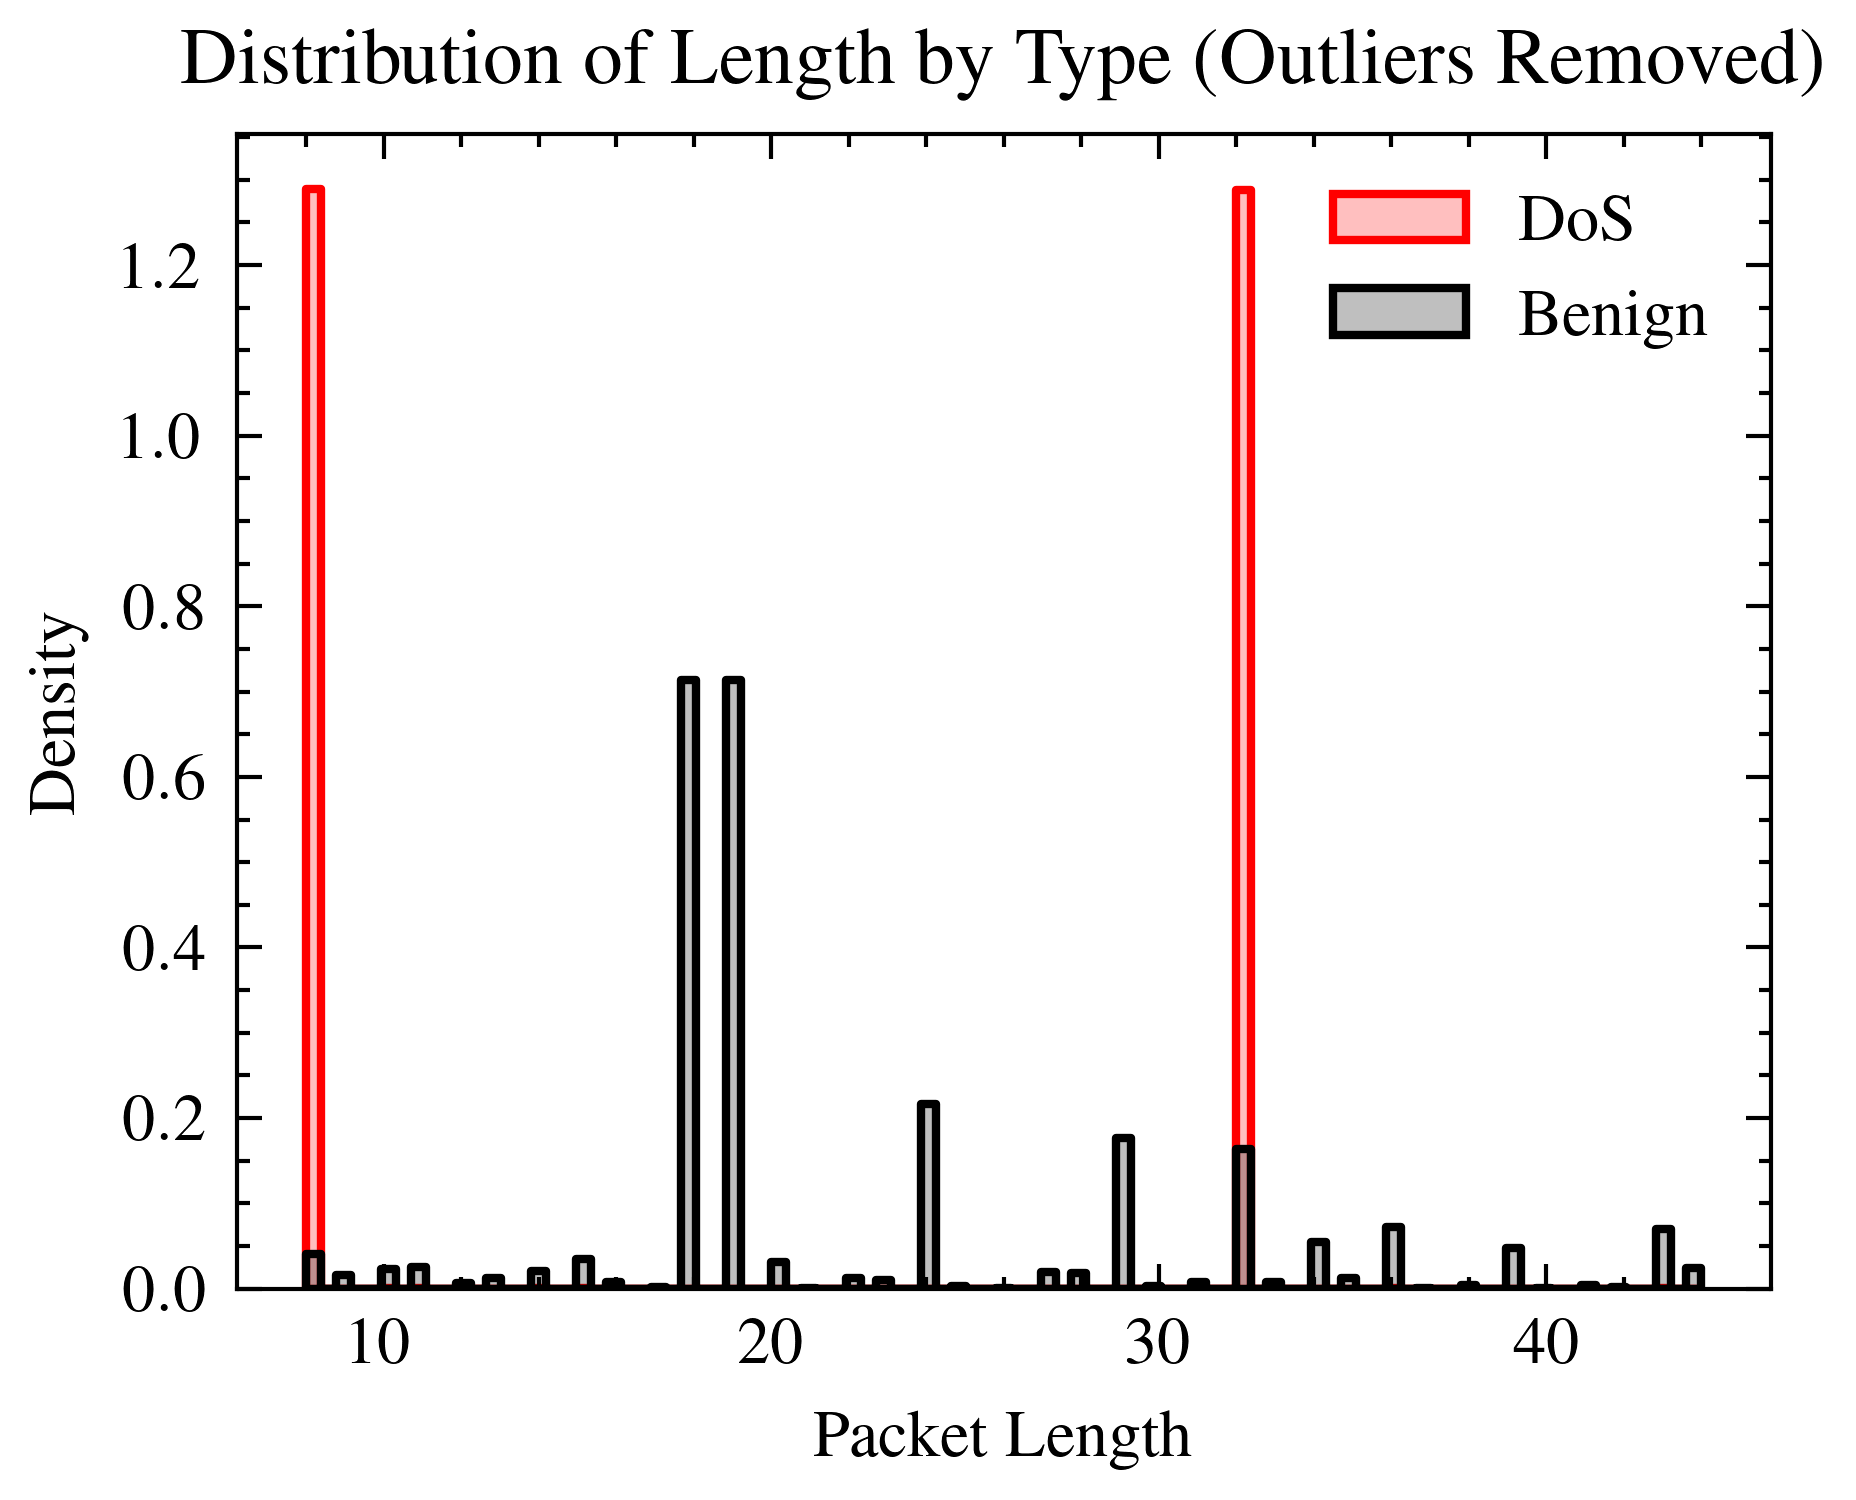

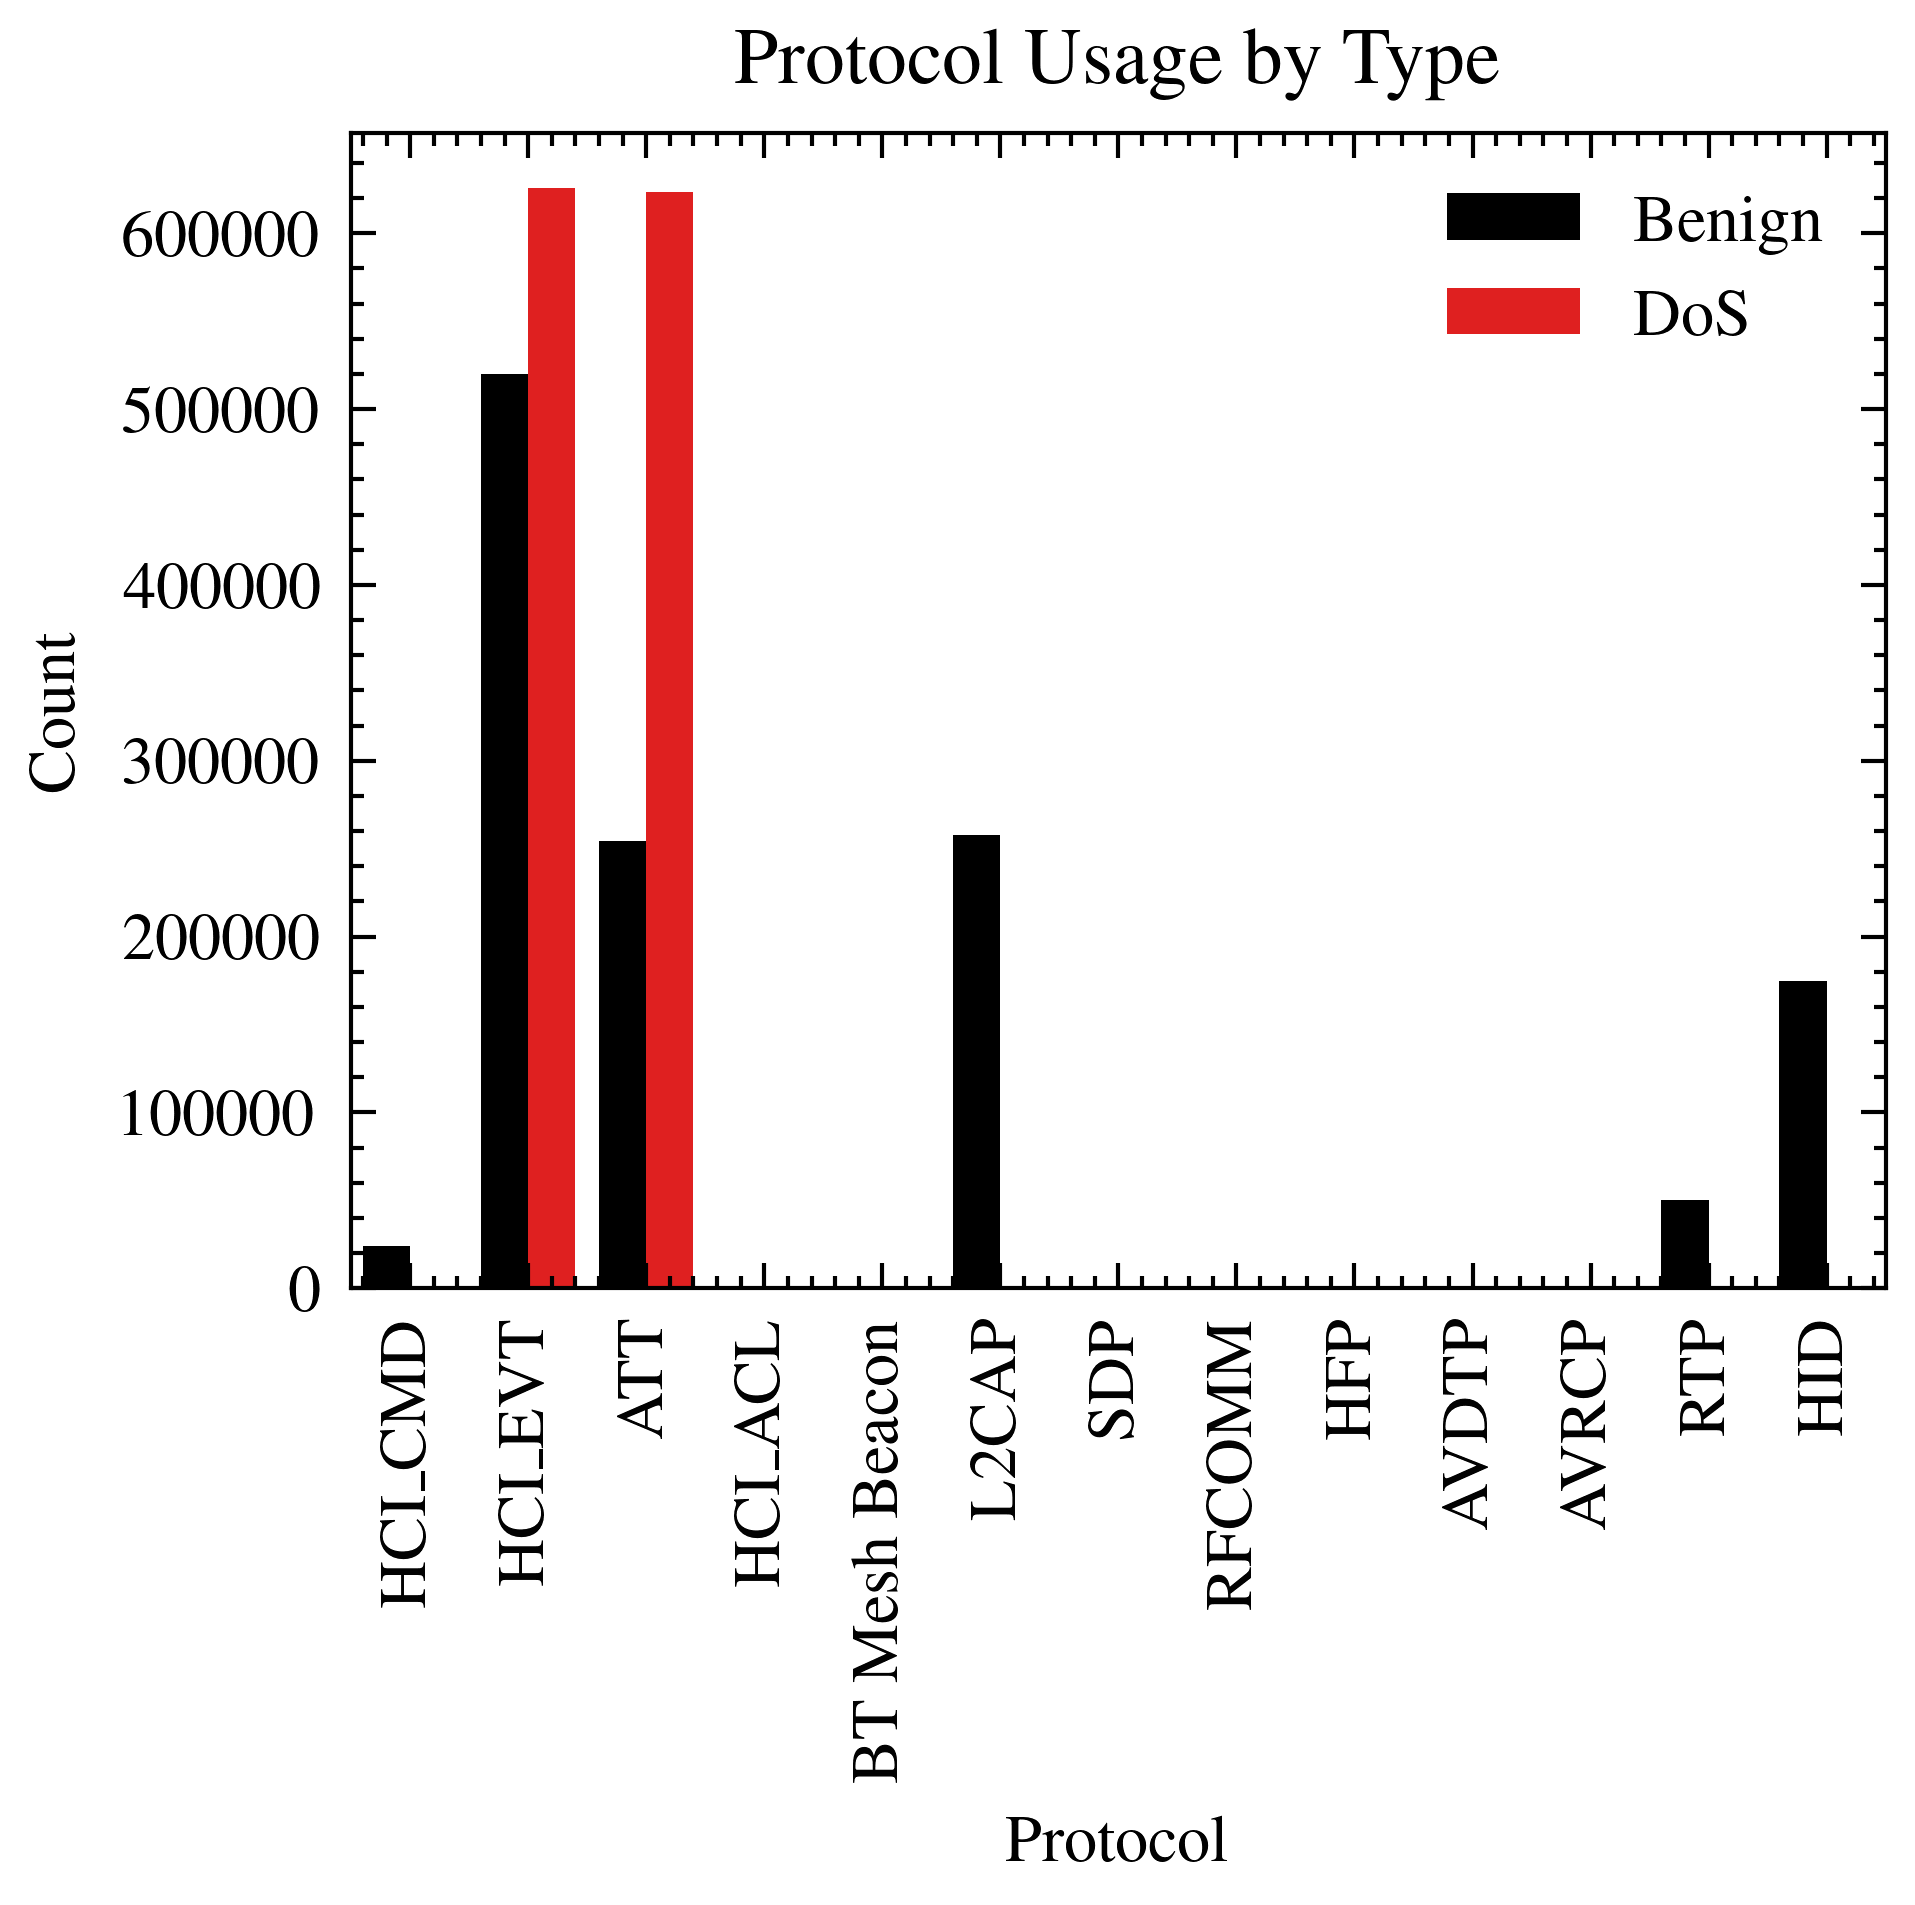

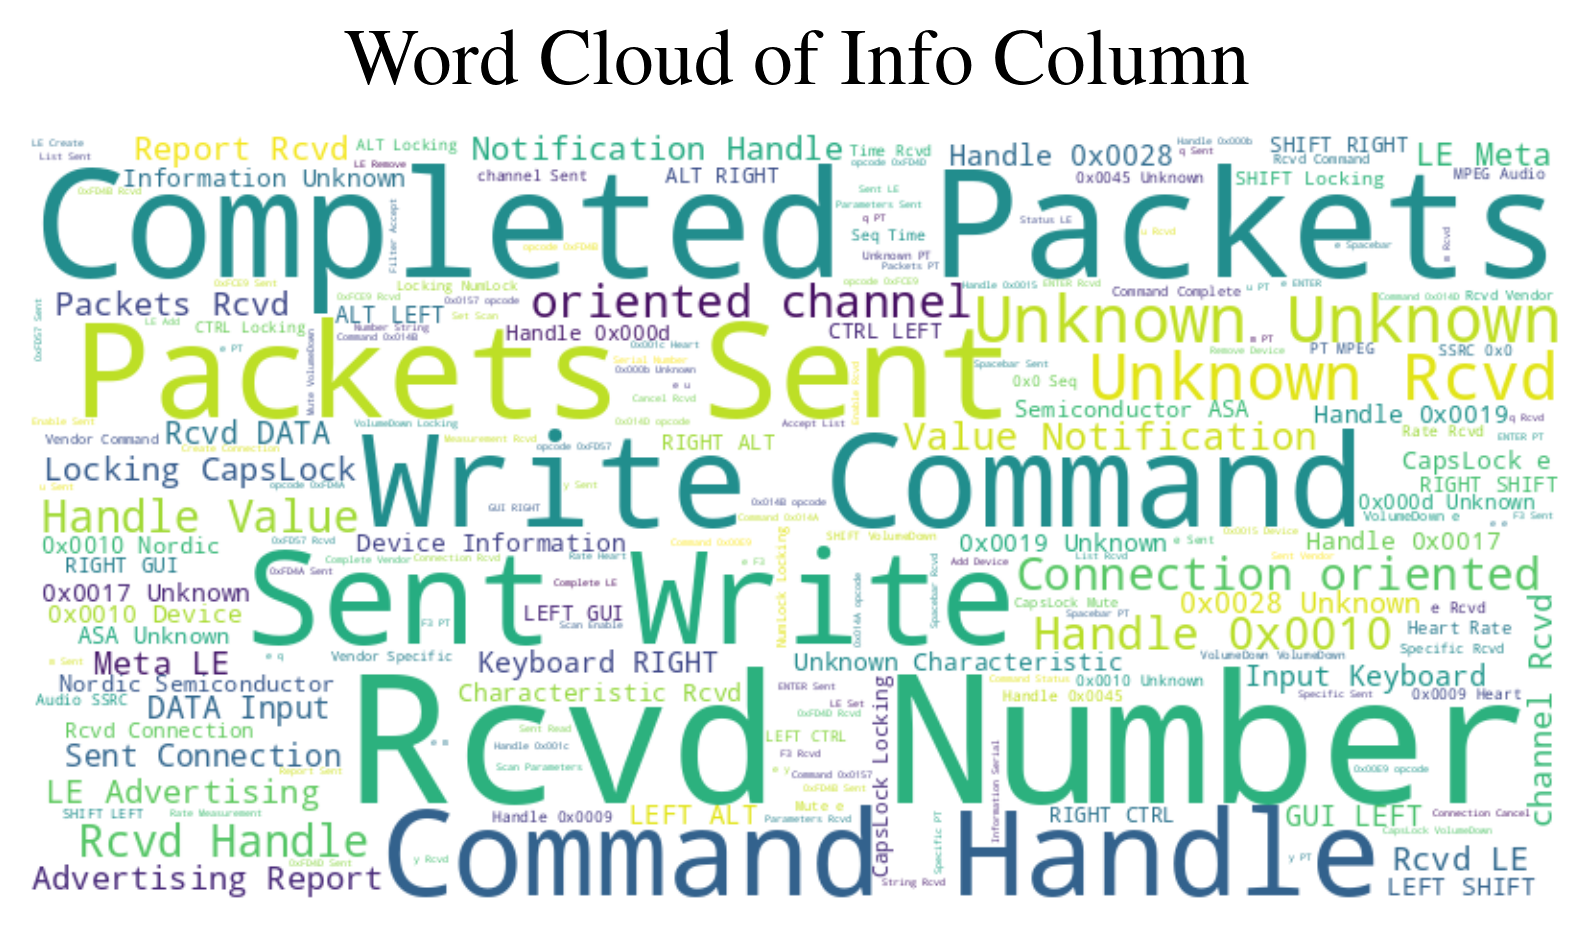

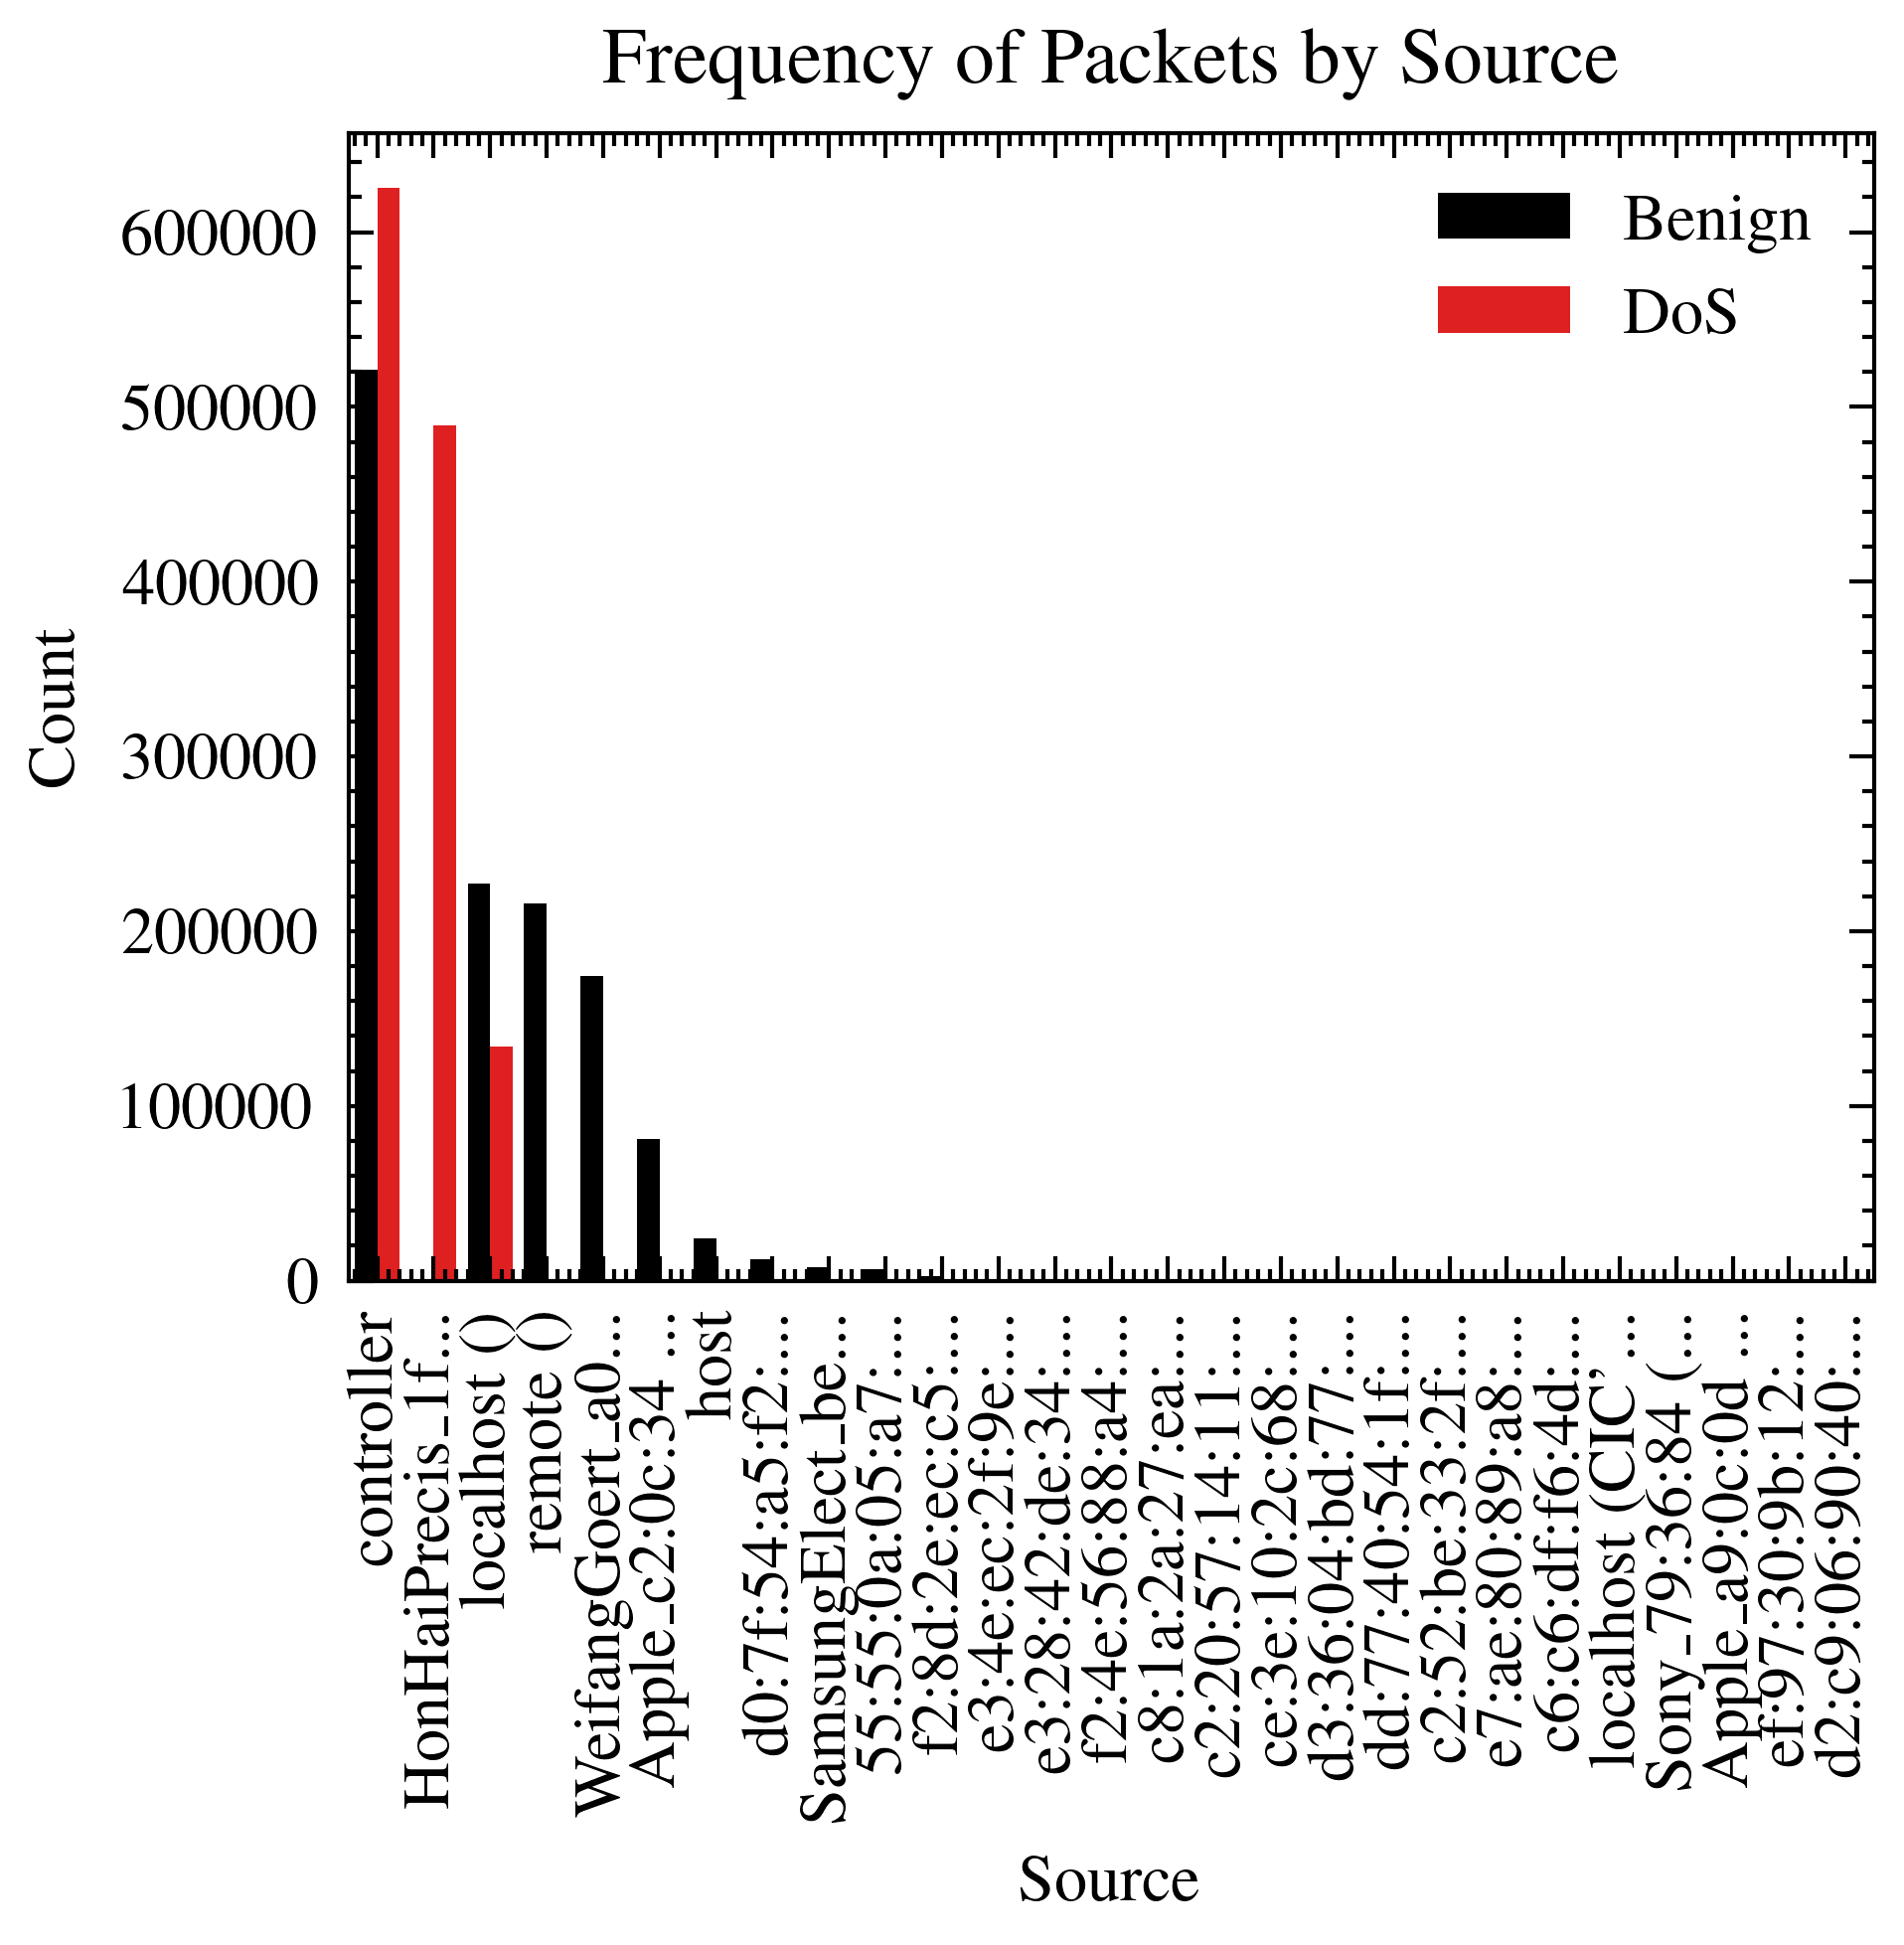

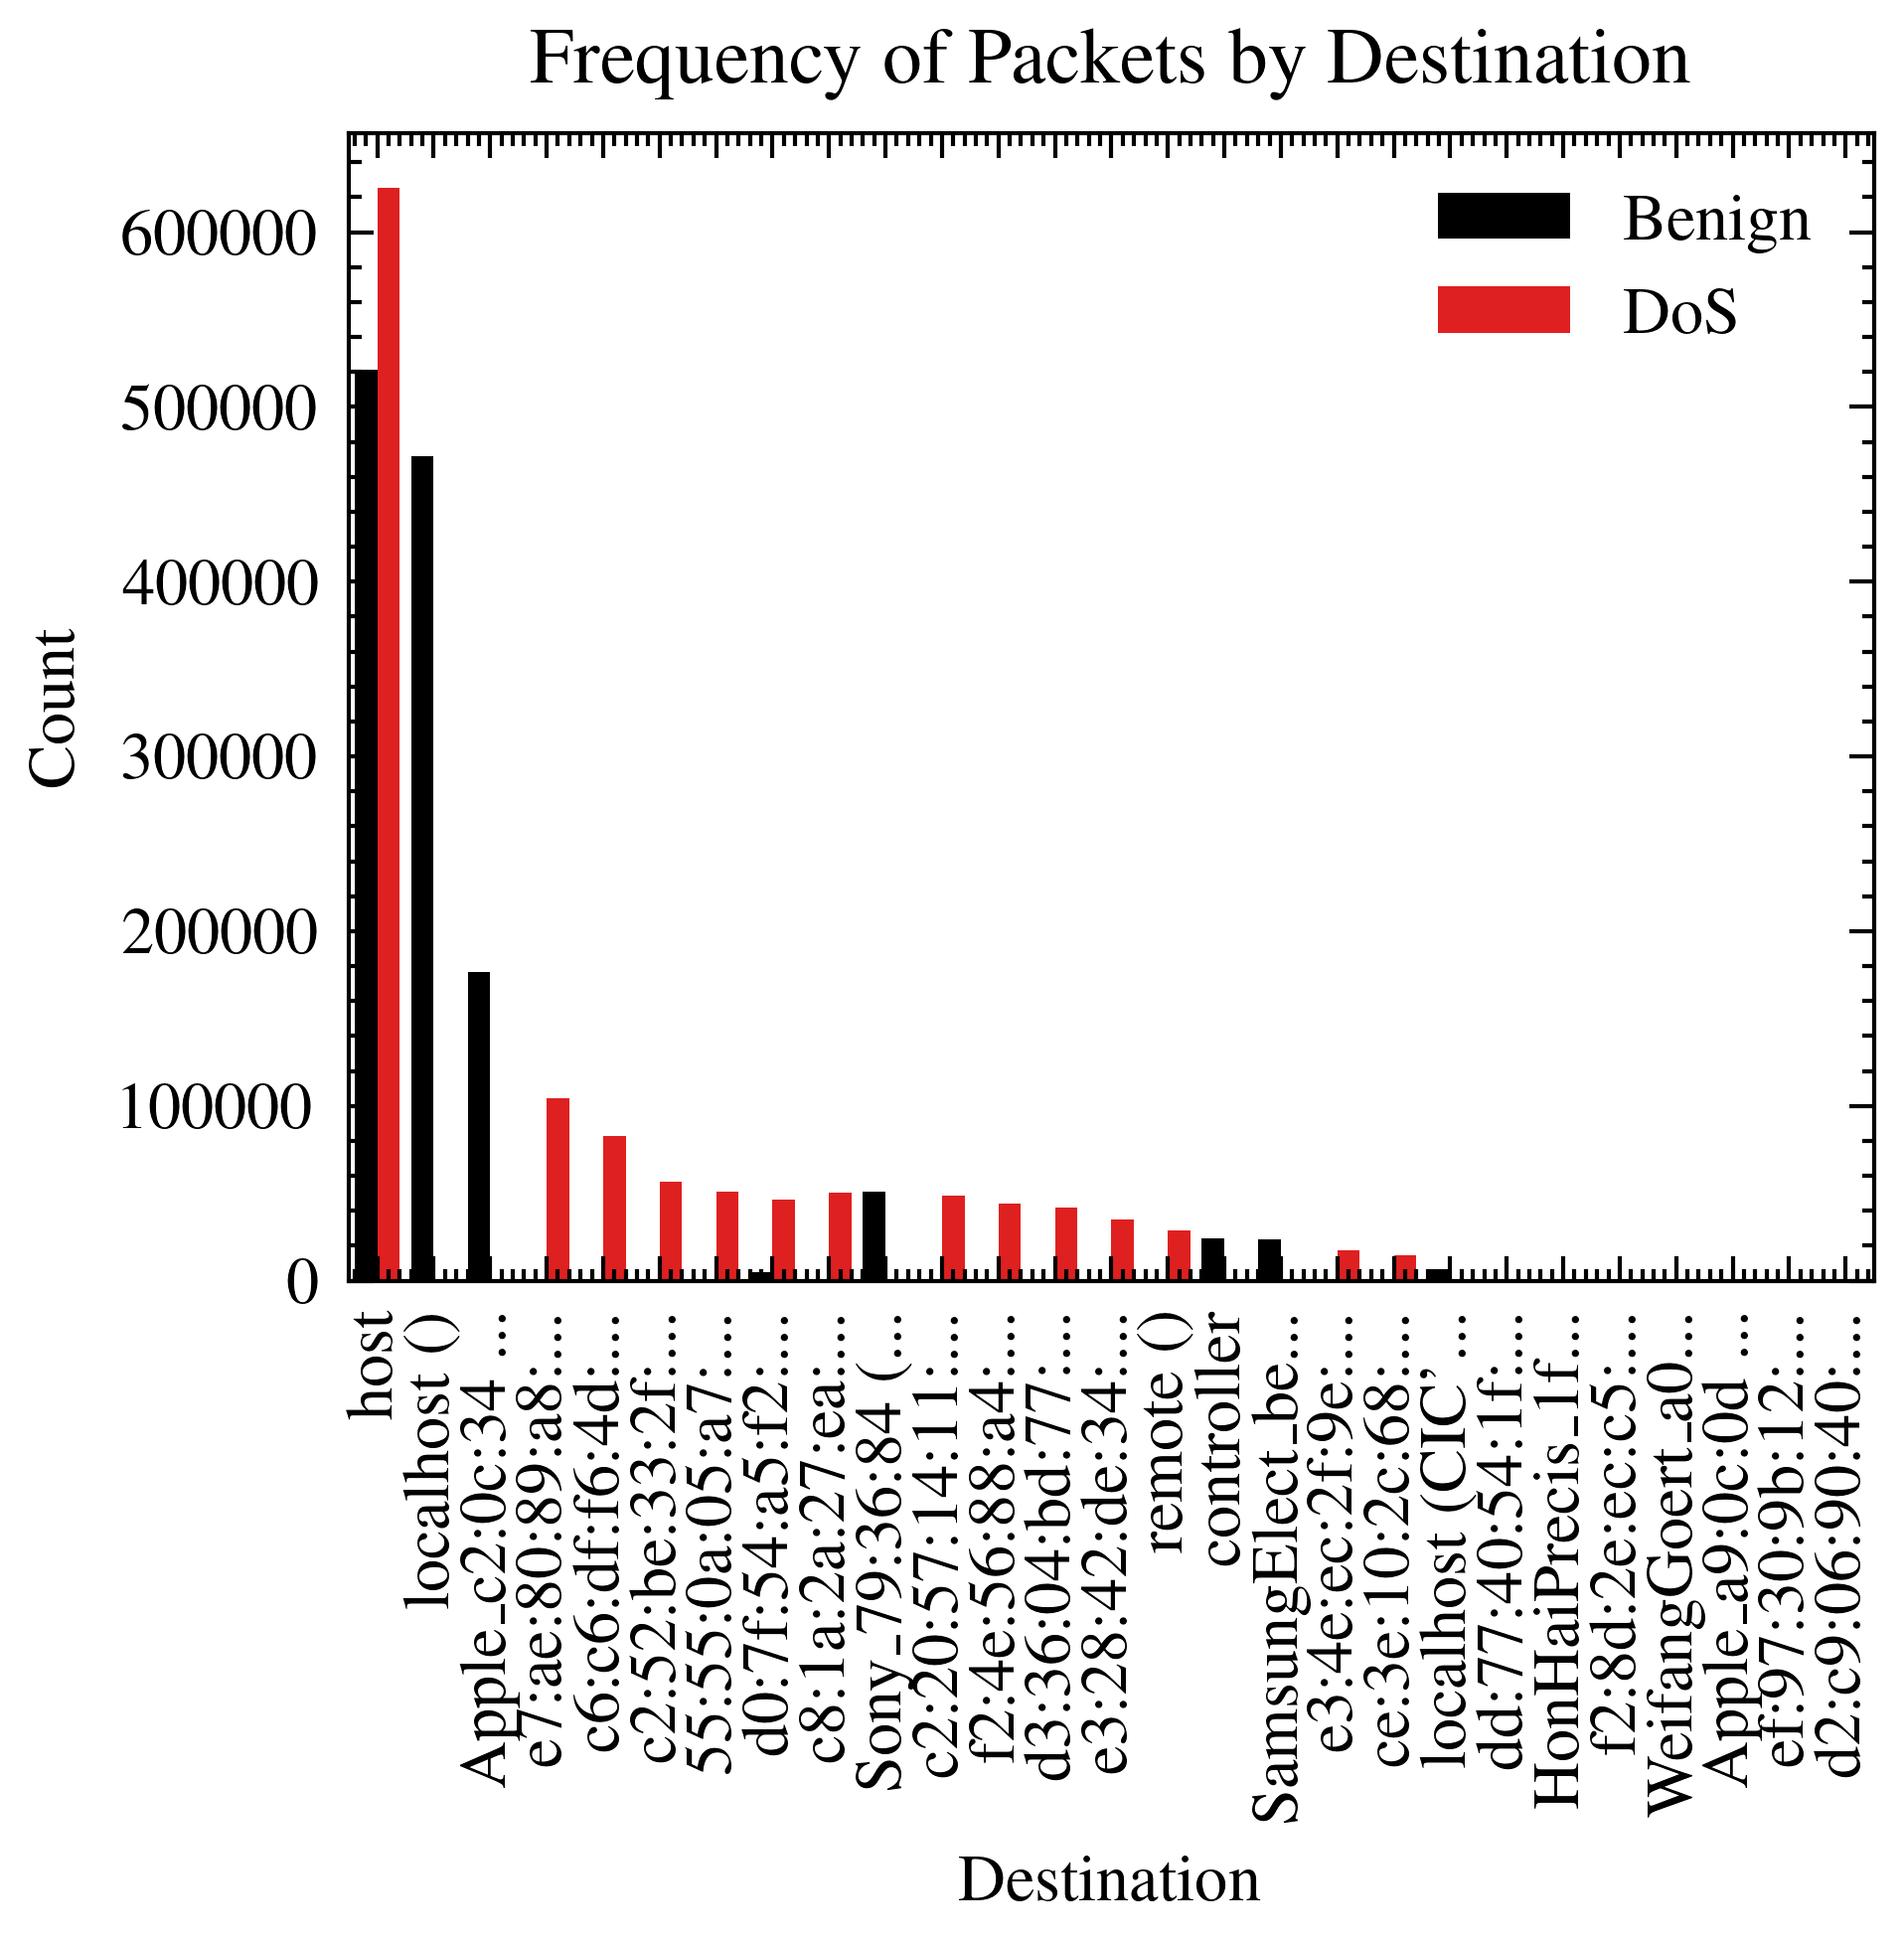

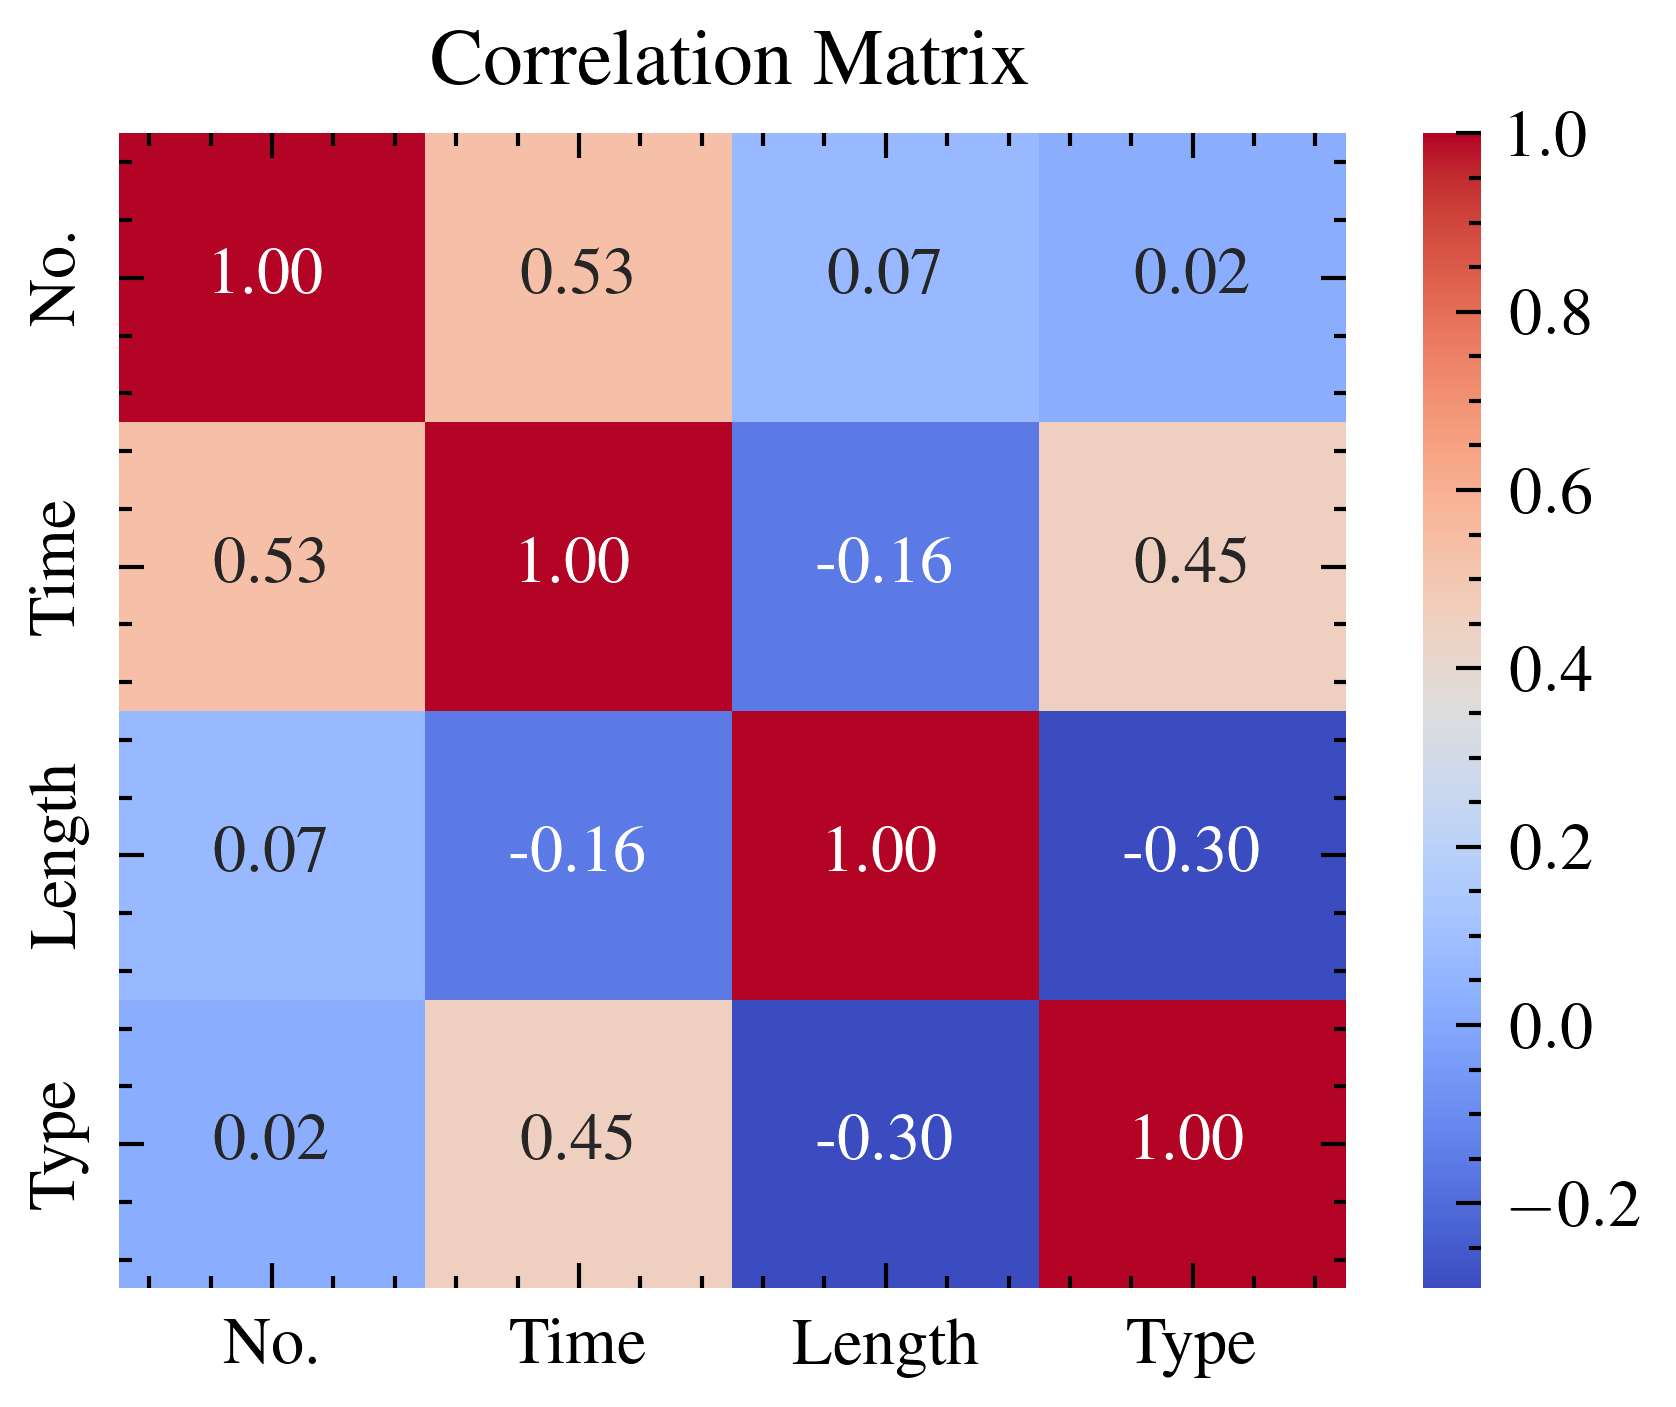

In [8]:
# training and testing with labels
plot_training = train_dataset.copy()
plot_training["Type"] = train_labels
plot_testing = test_dataset.copy()
plot_testing["Type"] = test_labels
dataset = pd.concat([plot_training, plot_testing], ignore_index=True)
# summary statistics
print(f"Training and Testing dataset statistics:\n{dataset.describe()}\n")

# remove length outliers
lower_bound, upper_bound = dataset["Length"].quantile([0.01, 0.85])
filtered_length = dataset["Length"][
    (dataset["Length"] > lower_bound) & (dataset["Length"] < upper_bound)
]
# histogram of length
plt.figure()
sns.histplot(
    x=filtered_length,
    hue=dataset["Type"],
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Distribution of Length by Type (Outliers Removed)")
plt.xlabel("Packet Length")
plt.ylabel("Density")
plt.legend(["DoS", "Benign"])
plt.show()

# bar chart for protocol usage
plt.figure()
sns.countplot(x="Protocol", hue="Type", data=dataset)
plt.title("Protocol Usage by Type")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# word cloud for info column
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(" ".join(dataset["Info"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Info Column")
plt.show()

# bar chart for source usage
dataset["Source"] = dataset["Source"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Source",
    hue="Type",
    data=dataset,
    order=dataset["Source"].value_counts().index,
)
plt.title("Frequency of Packets by Source")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# bar chart for destination usage
dataset["Destination"] = dataset["Destination"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Destination",
    hue="Type",
    data=dataset,
    order=dataset["Destination"].value_counts().index,
)
plt.title("Frequency of Packets by Destination")
plt.xlabel("Destination")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "DoS"])
plt.show()

# correlation matrix
plt.figure()
sns.heatmap(
    dataset.select_dtypes(["number"]).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Matrix")
plt.show()

## Feature Extraction

In [4]:
# load preprocessed datasets
train_dataset = pd.read_csv(PREPROCESSED_TRAIN)
test_dataset = pd.read_csv(PREPROCESSED_TEST)

In [9]:
# apply tf-idf vectorization to Info column
vectorizer = TfidfVectorizer(max_features=1000)
train_info = vectorizer.fit_transform(train_dataset["Info"])
test_info = vectorizer.transform(test_dataset["Info"])

# apply one-hot encoding to Protocol column
encoder = OneHotEncoder()
train_protocol = encoder.fit_transform(train_dataset[["Protocol"]])
test_protocol = encoder.transform(test_dataset[["Protocol"]])

# keep time column as is
train_time = csr_matrix(train_dataset[["Time"]])
test_time = csr_matrix(test_dataset[["Time"]])

# apply standard scaling to Length column
scaler = StandardScaler()
train_length = scaler.fit_transform(train_dataset[["Length"]])
test_length = scaler.transform(test_dataset[["Length"]])

# apply feature hashing to Source and Destination columns
hasher = FeatureHasher(n_features=20, input_type="string")
train_source = hasher.transform(train_dataset["Source"].apply(lambda x: [x]))  # type: ignore
test_source = hasher.transform(test_dataset["Source"].apply(lambda x: [x]))  # type: ignore
train_dest = hasher.transform(train_dataset["Destination"].apply(lambda x: [x]))  # type: ignore
test_dest = hasher.transform(test_dataset["Destination"].apply(lambda x: [x]))  # type: ignore

# combine features
train_features = hstack(
    [
        train_time,
        train_source,
        train_dest,
        train_protocol,
        train_length,
        train_info,
    ]
)
test_features = hstack(
    [
        test_time,
        test_source,
        test_dest,
        test_protocol,
        test_length,
        test_info,
    ]
)

In [6]:
# write features and models to files
save_npz(FEATURES_TRAIN, train_features)
save_npz(FEATURES_TEST, test_features)
_ = dump(vectorizer, VECTORIZER_MODEL)
_ = dump(encoder, ENCODER_MODEL)
_ = dump(scaler, SCALER_MODEL)
_ = dump(hasher, HASHER_MODEL)

TF-IDF Vocabulary size: 1000
One-Hot Encoding unique categories: 13
Standard Scaling features count: 1
Feature Hashing features count: 20
Total number of features: 1055


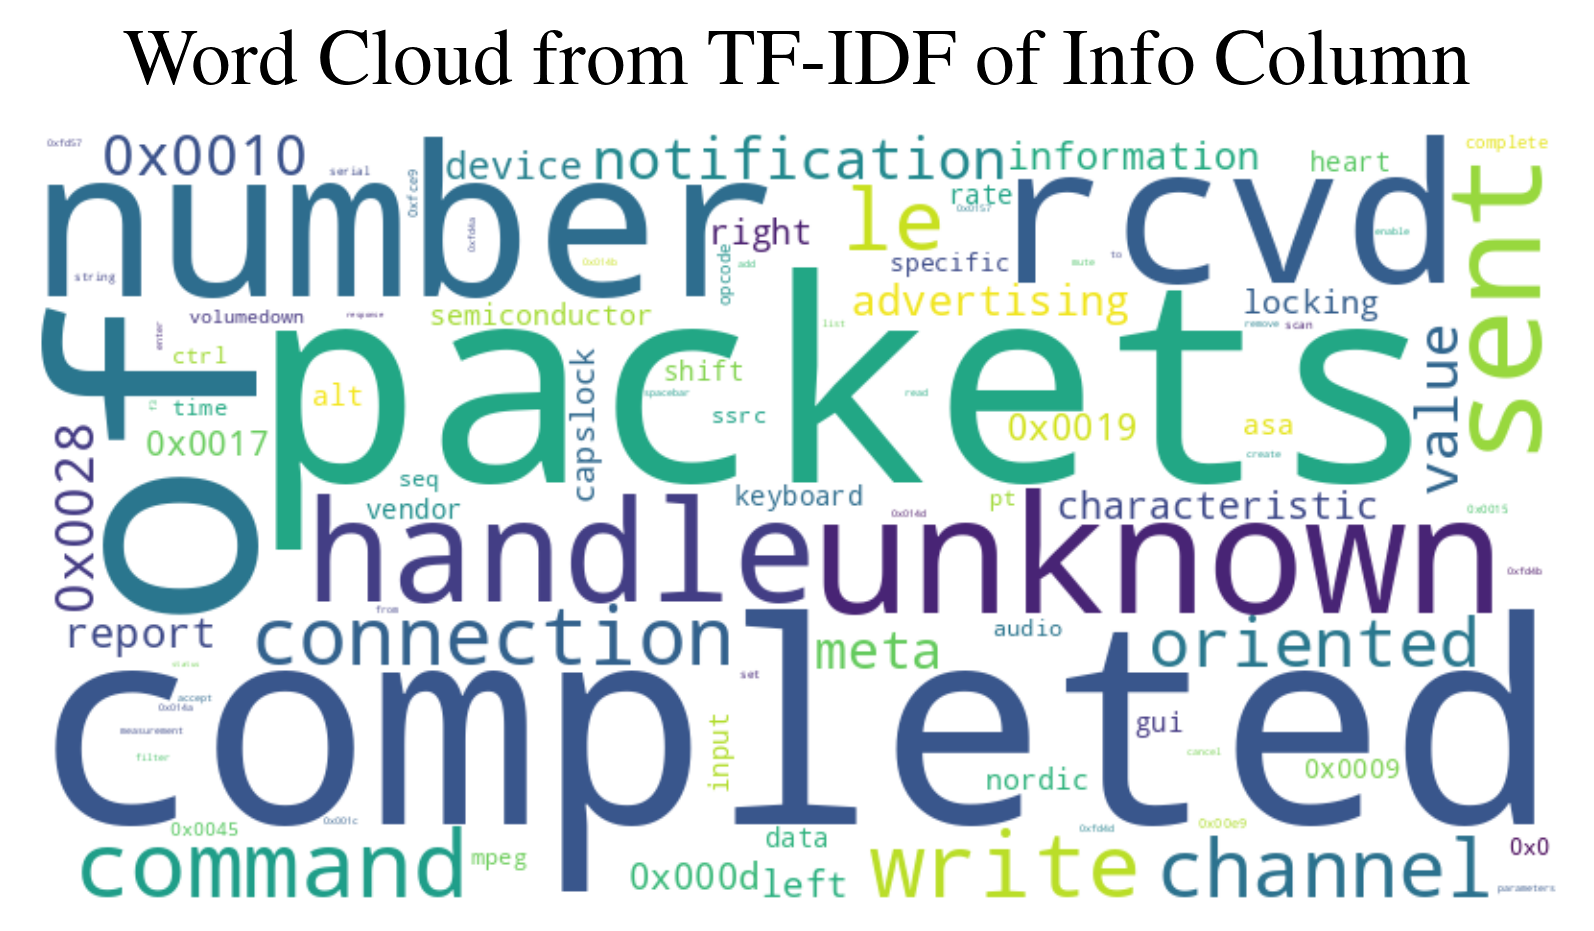

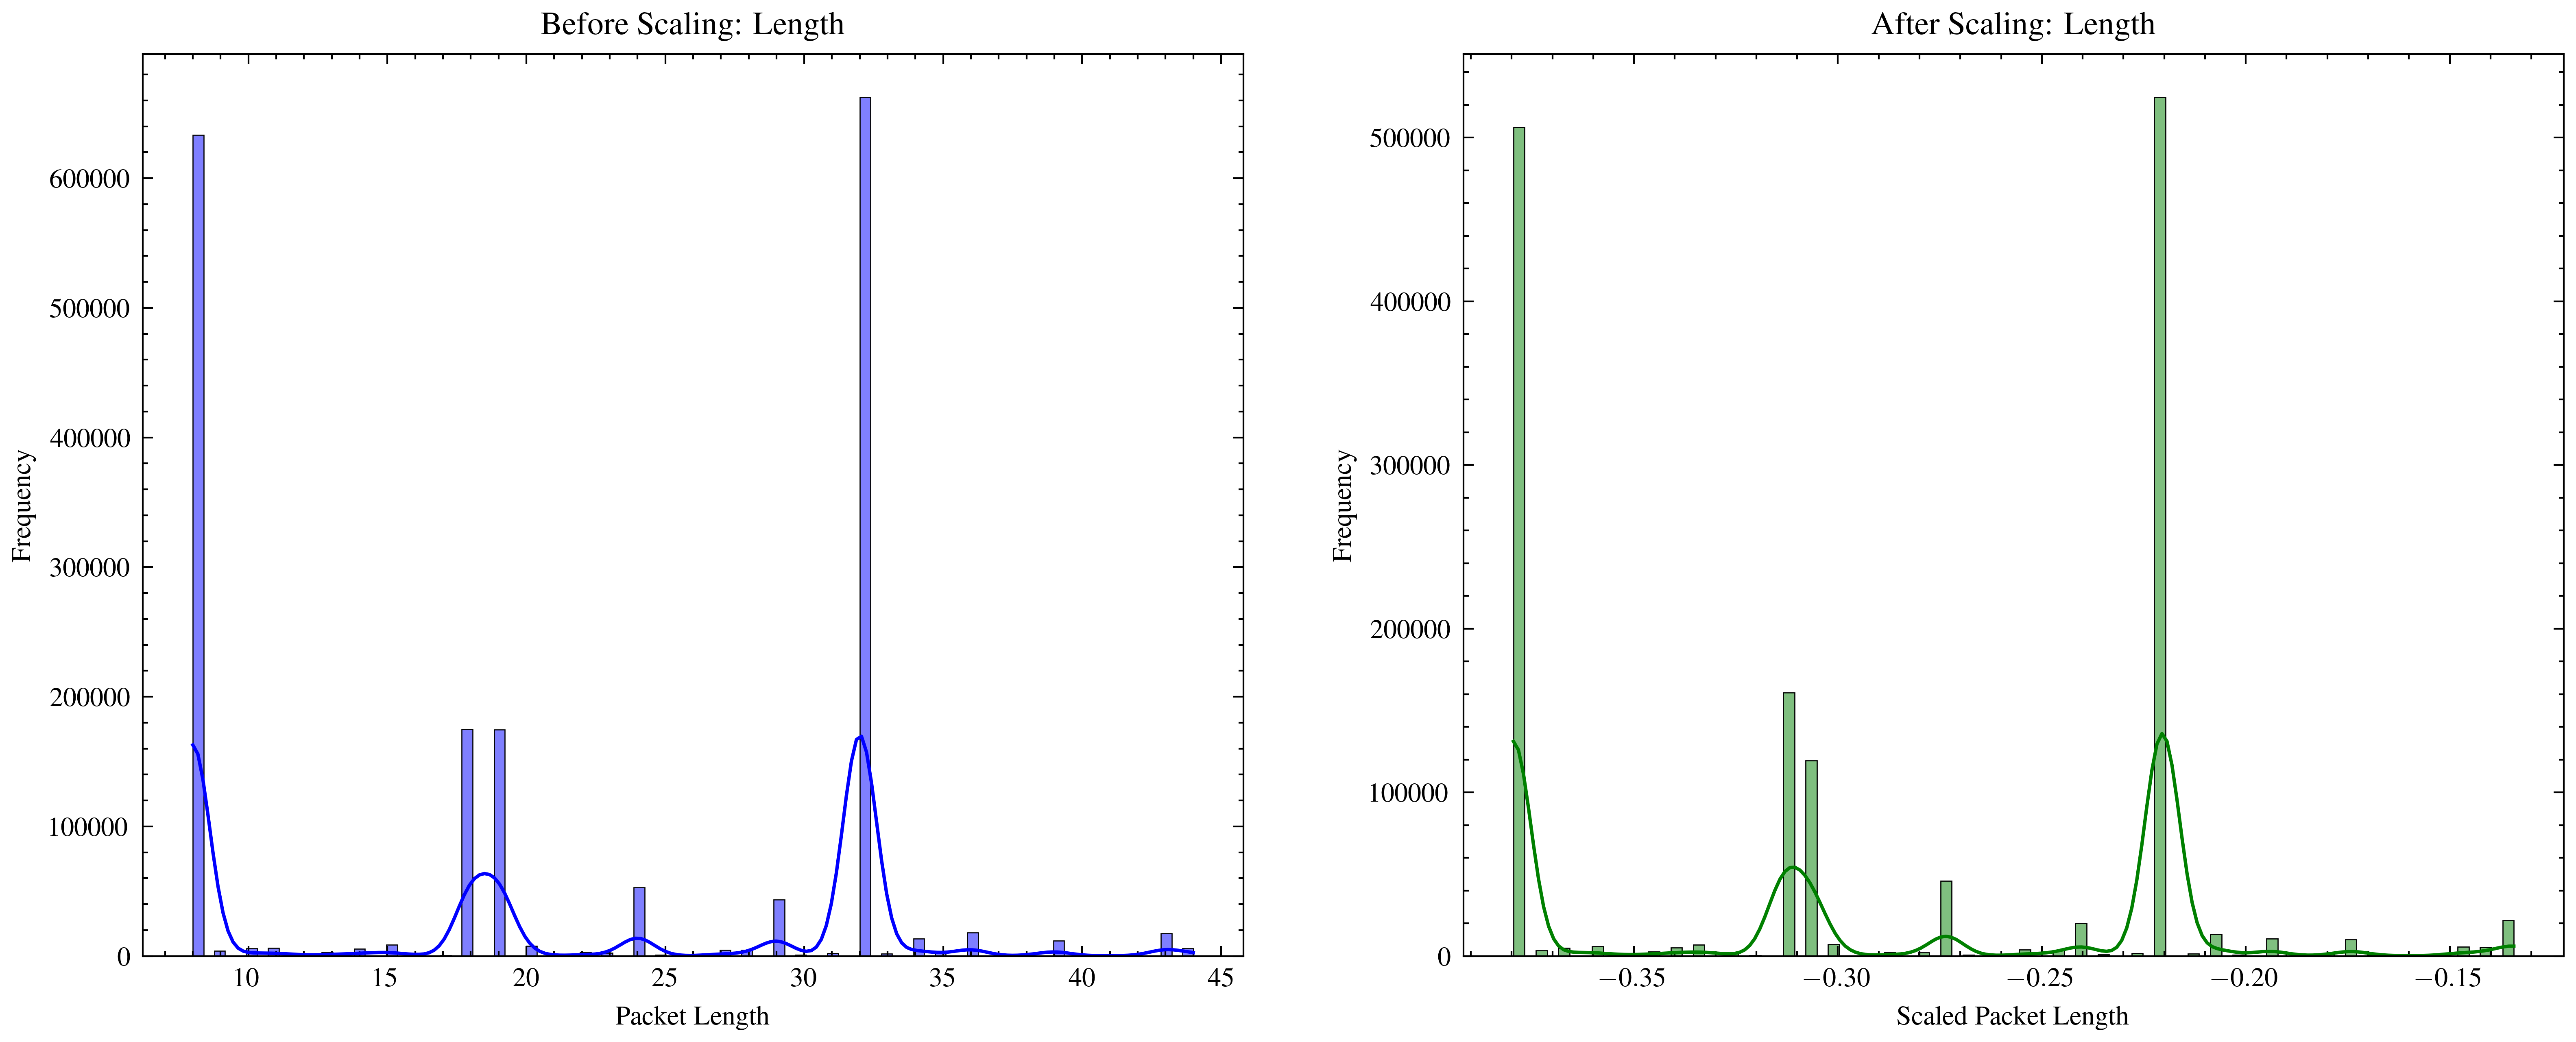

In [13]:
# report feature extraction results
print(f"TF-IDF Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"One-Hot Encoding unique categories: {len(encoder.categories_[0])}")  # type: ignore
print(f"Standard Scaling features count: {train_length.shape[1]}")
print(f"Feature Hashing features count: {train_source.shape[1]}")
print(f"Total number of features: {train_features.shape[1]}")

# word cloud of the info column
features = vectorizer.get_feature_names_out()
scores = np.ravel(train_info.sum(axis=0))

word_scores = dict(zip(features, scores))
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(word_scores)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from TF-IDF of Info Column")
plt.show()


# remove outliers
train_length_series = pd.Series(train_length.ravel())
lower_bound, upper_bound = train_length_series.quantile([0.01, 0.85])
filtered_length = train_length[
    (train_length > lower_bound) & (train_length < upper_bound)
]
lower_bound, upper_bound = dataset["Length"].quantile([0.01, 0.85])
filtered_original_length = dataset["Length"][
    (dataset["Length"] > lower_bound) & (dataset["Length"] < upper_bound)
]
# histograms of the Length column before and after scaling
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
sns.histplot(filtered_original_length, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Before Scaling: Length")
ax[0].set_xlabel("Packet Length")
ax[0].set_ylabel("Frequency")
sns.histplot(filtered_length, kde=True, ax=ax[1], color="green")
ax[1].set_title("After Scaling: Length")
ax[1].set_xlabel("Scaled Packet Length")
ax[1].set_ylabel("Frequency")
plt.show()

## Model Training

In [8]:
# load features and labels
train_features = load_npz(FEATURES_TRAIN)
train_labels = np.load(LABELS_TRAIN)

In [9]:
# report hardware information
print("Hardware information:")
print(f"\tPlatform: {os.uname().sysname}")
print(f"\tProcessor: {os.uname().machine}")
print(f"\tNumber of CPU cores: {os.cpu_count()}")
mem = os.sysconf("SC_PAGE_SIZE") * os.sysconf("SC_PHYS_PAGES") / 1024**3
print(f"\tMemory available: {mem:.2f} GB\n")

# train model
model = GradientBoostingClassifier(verbose=1)
_ = model.fit(train_features, train_labels)  # type: ignore

Hardware information:
	Platform: Darwin
	Processor: arm64
	Number of CPU cores: 8
	Memory available: 8.00 GB

      Iter       Train Loss   Remaining Time 
         1           1.2406            3.79m
         2           1.1213            3.74m
         3           1.0191            3.69m
         4           0.9327            3.84m
         5           0.8490            3.78m
         6           0.7794            3.74m
         7           0.7178            3.64m
         8           0.6677            3.56m
         9           0.5945            3.50m
        10           0.5316            3.44m
        20           0.2107            3.00m
        30           0.1111            2.61m
        40           0.0674            2.26m
        50           0.0481            1.88m
        60           0.0359            1.51m
        70           0.0288            1.12m
        80           0.0232           44.62s
        90           0.0192           22.09s
       100           0.0173       

In [10]:
# write model to file
_ = dump(model, GBM_MODEL)

## Evaluation

In [11]:
# load model and features
model = load(GBM_MODEL)
vectorizer = load(VECTORIZER_MODEL)
encoder = load(ENCODER_MODEL)
scaler = load(SCALER_MODEL)
hasher = load(HASHER_MODEL)
test_features = load_npz(FEATURES_TEST)
test_labels = np.load(LABELS_TEST)

Train accuracy: 0.9968155144577964

Confusion matrix:
[[264286   1201]
 [   446 251262]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    265487
           1       1.00      1.00      1.00    251708

    accuracy                           1.00    517195
   macro avg       1.00      1.00      1.00    517195
weighted avg       1.00      1.00      1.00    517195



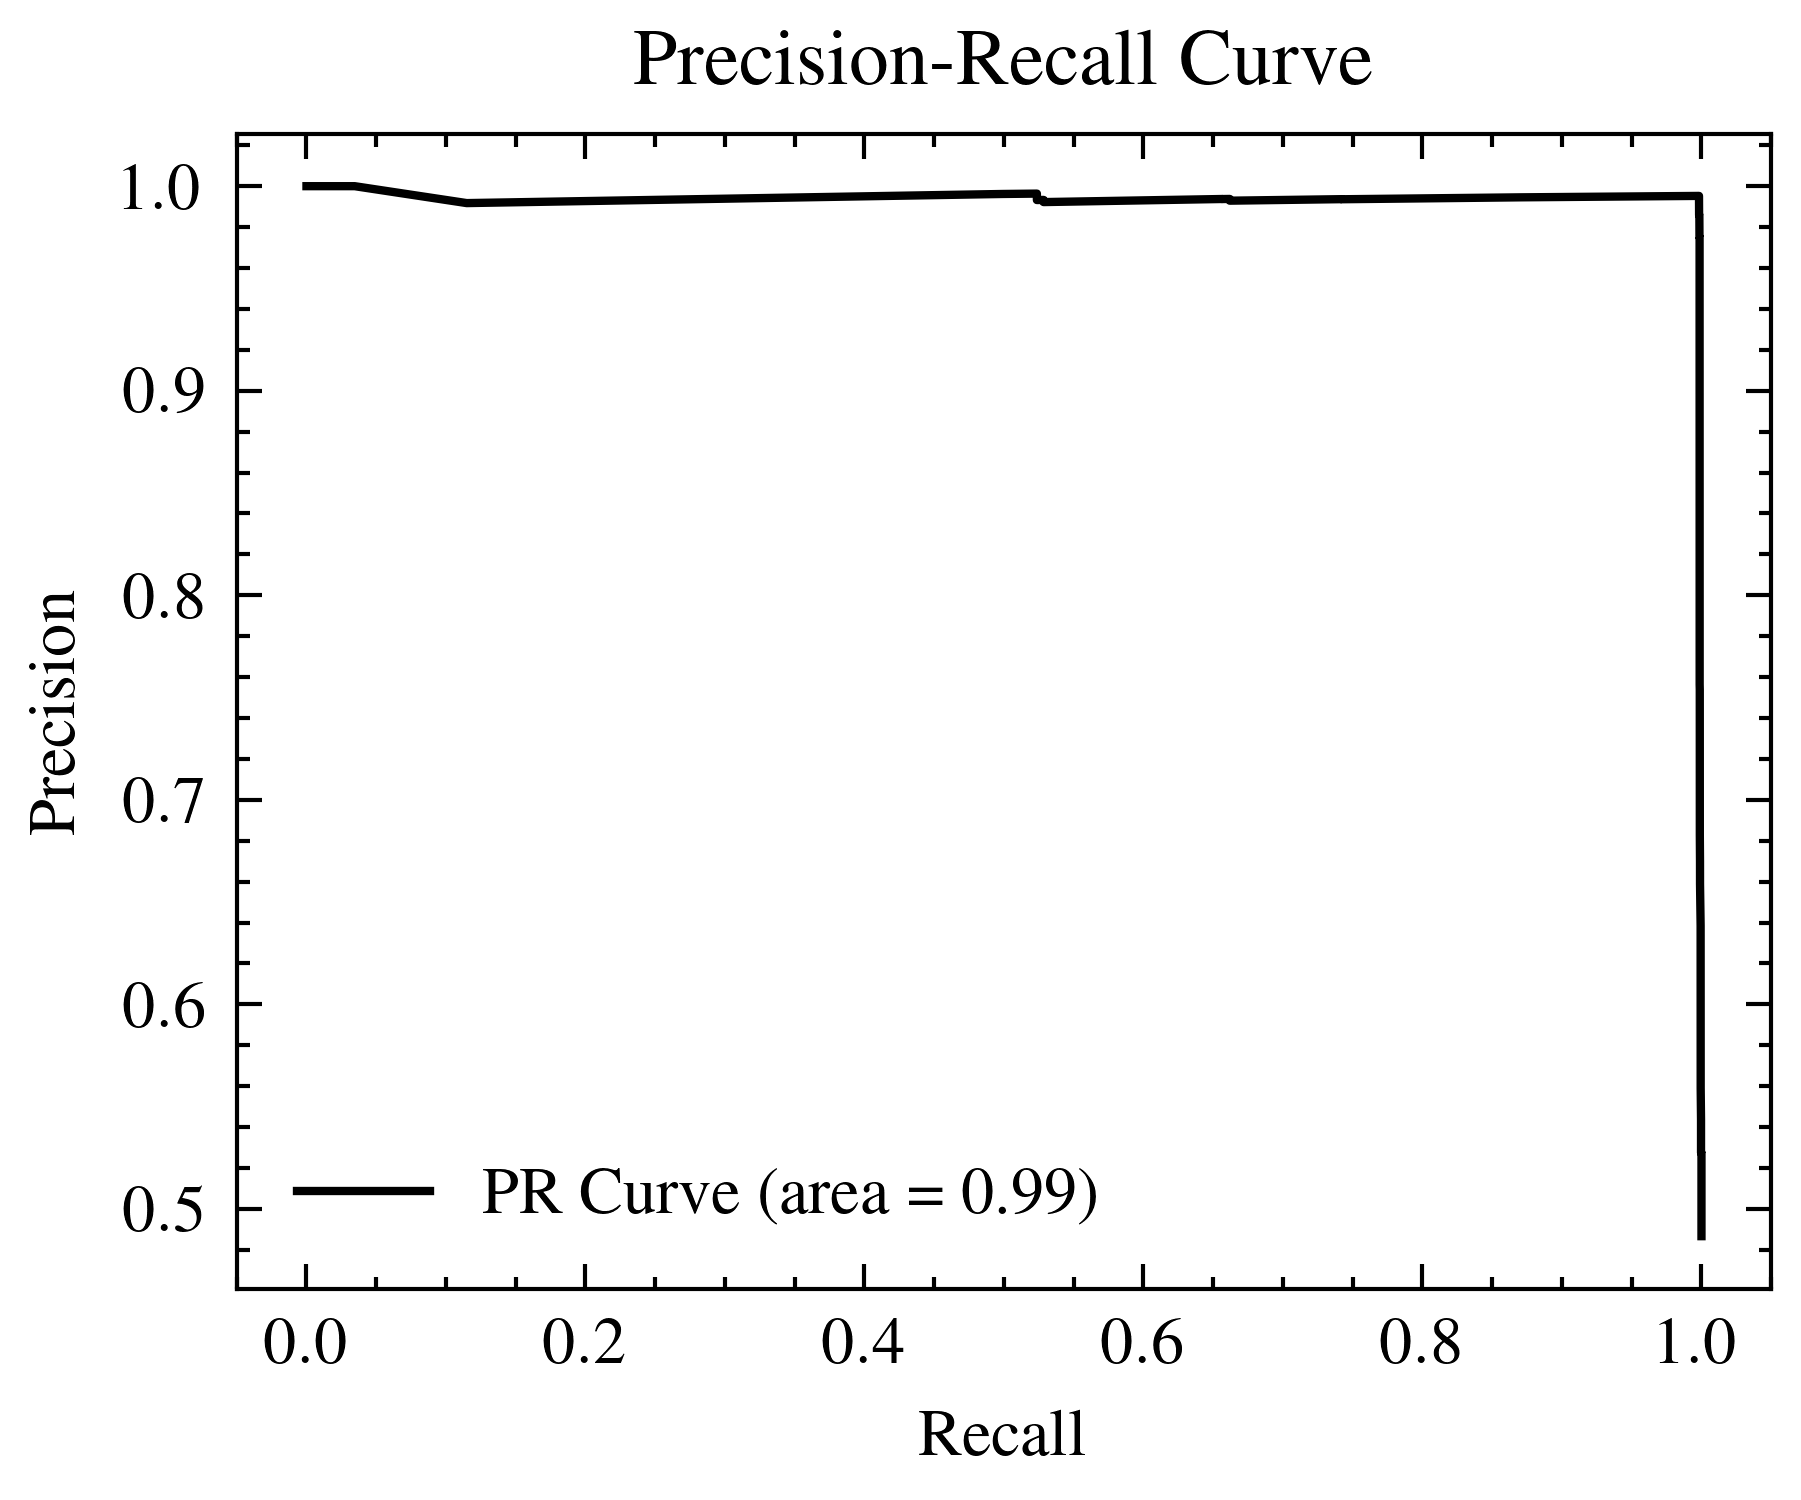

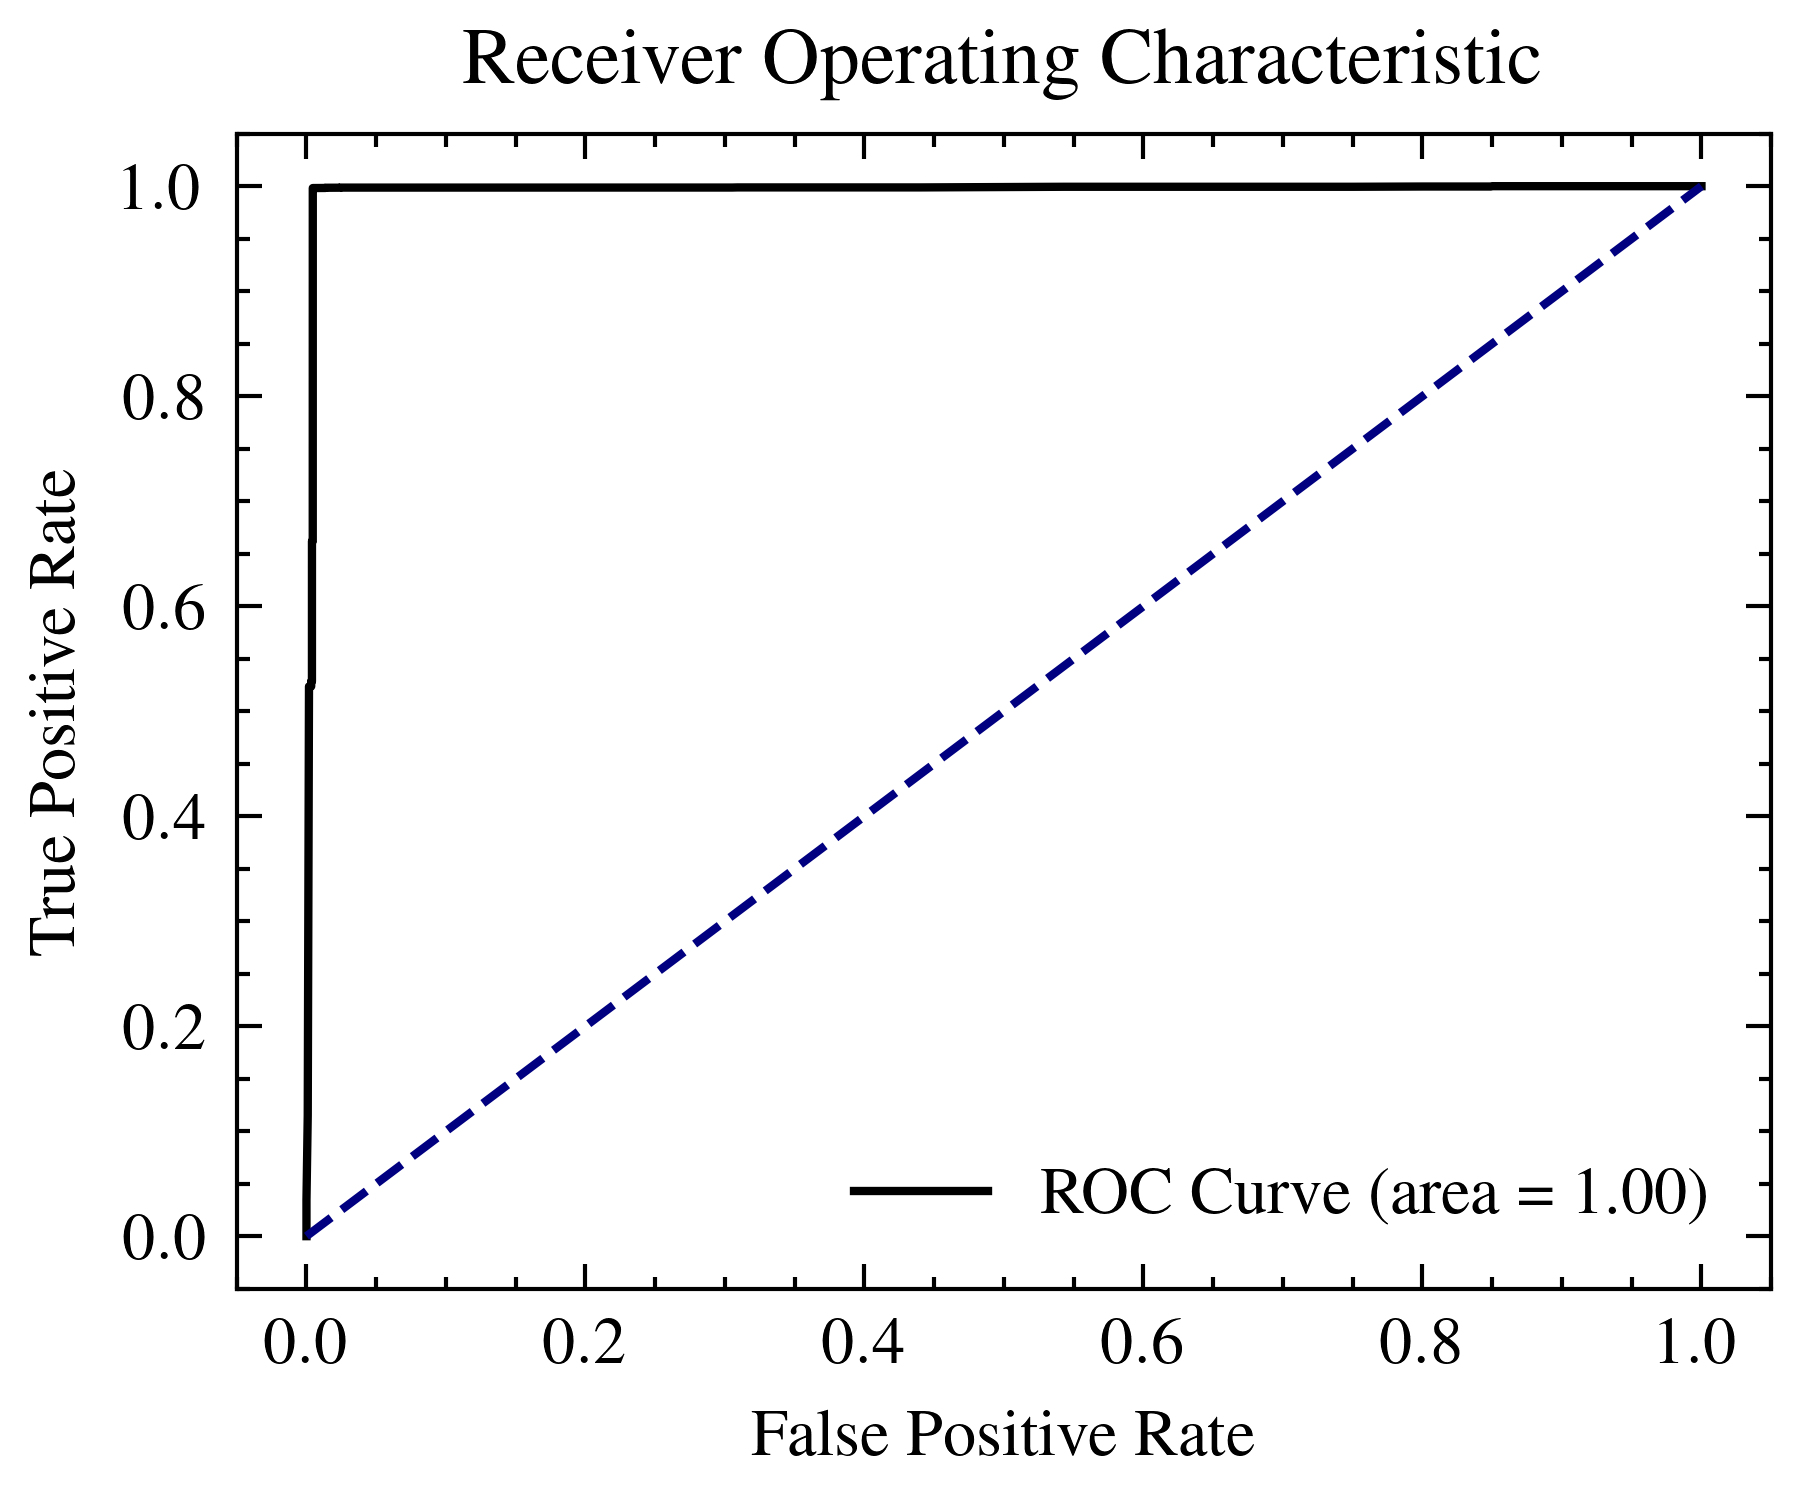

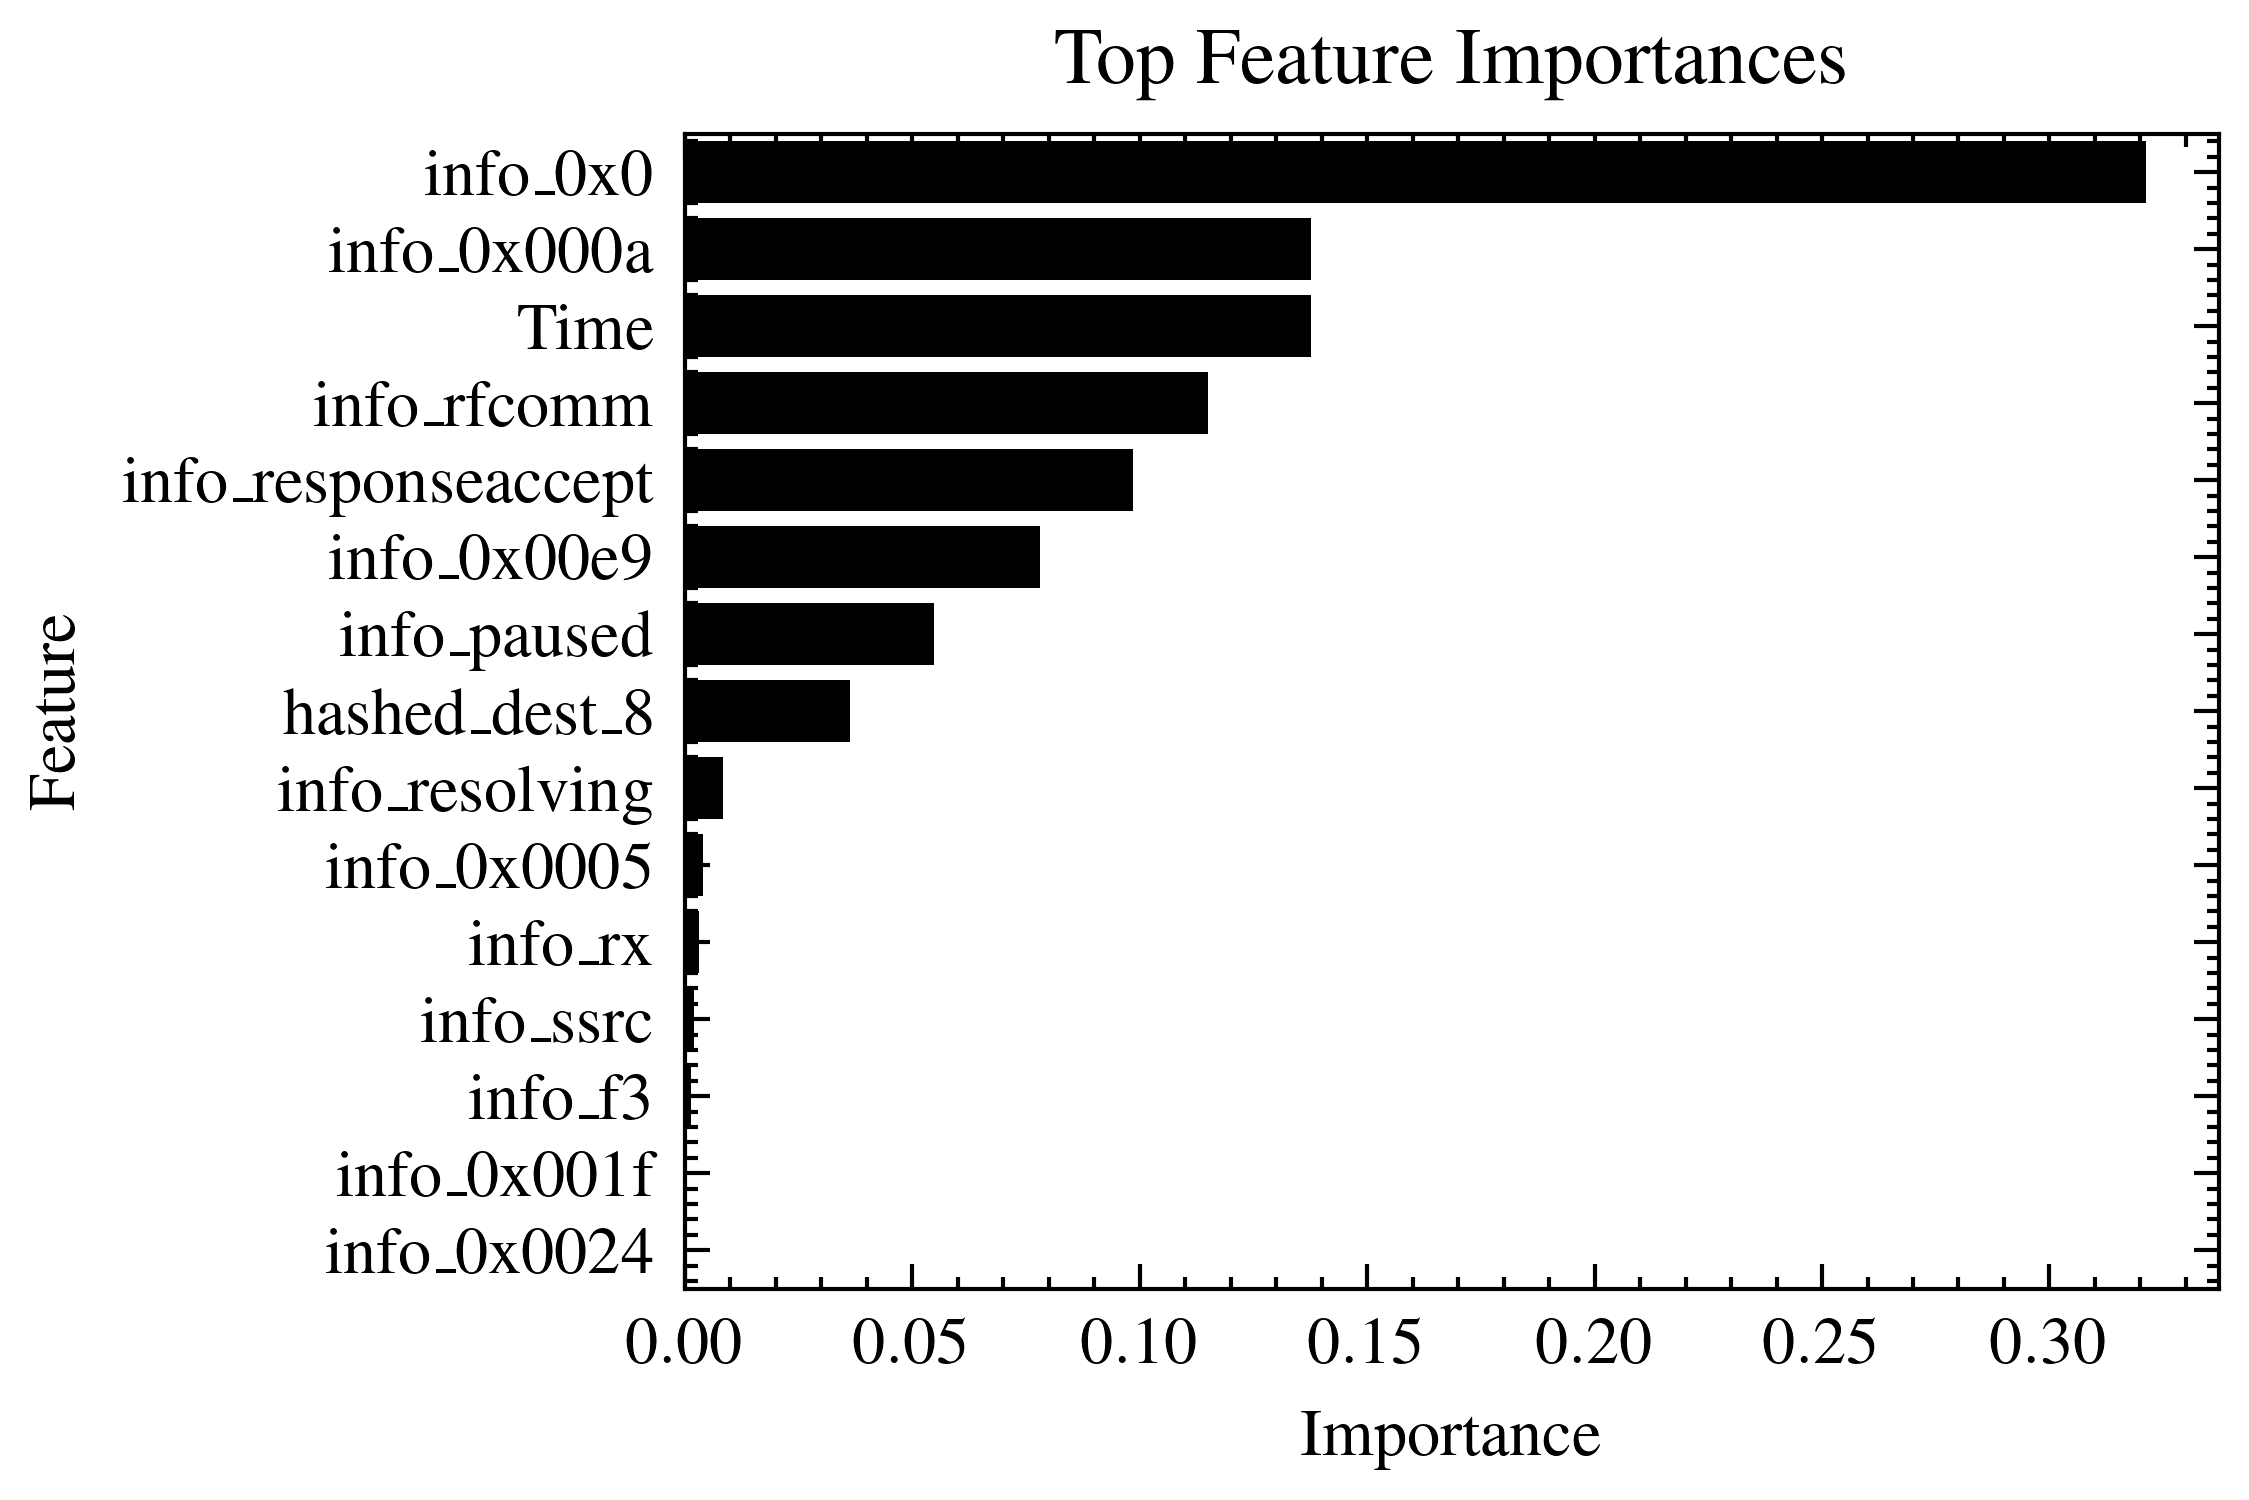

In [14]:
# predictions
predictions = model.predict(test_features)
predictions_prob = model.predict_proba(test_features)[:, 1]

# evaluate model
accuracy = metrics.accuracy_score(test_labels, predictions)
print(f"Train accuracy: {accuracy}\n")
conf_matrix = metrics.confusion_matrix(test_labels, predictions)
print(f"Confusion matrix:\n{conf_matrix}\n")
report = metrics.classification_report(test_labels, predictions)
print(f"Classification report:\n{report}")

# compute precision-recall curve and area
precision, recall, _ = metrics.precision_recall_curve(
    test_labels, predictions_prob
)
pr_auc = metrics.auc(recall, precision)
# plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f"PR Curve (area = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# compute roc curve and area
fpr, tpr, _ = metrics.roc_curve(test_labels, predictions_prob)
roc_auc = metrics.auc(fpr, tpr)
# plot roc curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# prepare feature names
tfidf_features = [
    "info_" + feature for feature in vectorizer.get_feature_names_out()
]
onehot_features = [
    "protocol_" + feature for feature in encoder.get_feature_names_out()
]
hashed_src_features = [f"hashed_src_{i}" for i in range(train_source.shape[1])]
hashed_dest_features = [f"hashed_dest_{i}" for i in range(train_dest.shape[1])]
# combine all feature names
all_feature_names = (
    list(tfidf_features)
    + list(onehot_features)
    + list(hashed_src_features)
    + list(hashed_dest_features)
    + ["Time", "Length"]
)
# ensure the number of names matches the number of features
assert len(all_feature_names) == train_features.shape[1]

# prepare feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": all_feature_names, "Importance": importances}
)
sorted_feature_importance = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# plot feature importance
top_features = sorted_feature_importance.head(15)  # top n features
plt.figure()
sns.barplot(x="Importance", y="Feature", data=top_features)
plt.title("Top Feature Importances")
plt.show()